In [1]:
from math import pi, sqrt
from cmath import exp
from qiskit.opflow import One, StateFn, Zero, Plus
from qiskit.quantum_info import Statevector

from dbcquantum.circuit import AssertQuantumCircuit
from dbcquantum.utils import (
    bin_frac_to_dec,
    eq_state,
    split_each_qubit_states,
)

In [2]:
def make_qft(n: int) -> AssertQuantumCircuit:
    from qiskit.circuit.library import QFT
    qft = AssertQuantumCircuit(num_qubits=n)
    qft.append(QFT(n), range(n))

    for i in range(qft.num_qubits):
        qft.add_pre_condition(
            f"QFT: qubit {i} must be |0> or |1>.",
            lambda pre: eq_state(pre, Zero) or eq_state(pre, One),
            focus_qubits=[i],
        )

    def condition(pre: Statevector, post: Statevector) -> bool:
        # example: |0010> -> [|0>, |1>, |0>, |0>]
        splitted_input_state: list[Statevector] = split_each_qubit_states(
            pre
        )

        # example:[|0>, |1>, |0>, |0>] -> [0,1,0,0]
        pre_01: list[int] = [
            0 if eq_state(state, Zero) else 1 for state in splitted_input_state
        ]

        expected = StateFn("")
        for i in range(0, n):
            coeff = exp(
                2j * pi * bin_frac_to_dec(pre_01[0:i+1])
            )
            # print(input_state_01[0:i+1])
            expected = expected ^ ((1 / sqrt(2)) * (Zero + coeff * One))  # type: ignore
        return eq_state(post, expected)

    qft.add_condition("QFT: state and phase.", condition)

    return qft

In [3]:
qft = make_qft(4)
qft.run(init_state=Zero ^ Zero ^ One ^ Zero)
# j_0 = Zero, j_1 = One, j_2 = Zero, j_3 = Zero

Statevector([ 2.50000000e-01+0.j       ,  1.76776695e-01+0.1767767j,
              1.53080850e-17+0.25j     , -1.76776695e-01+0.1767767j,
             -2.50000000e-01+0.j       , -1.76776695e-01-0.1767767j,
             -1.53080850e-17-0.25j     ,  1.76776695e-01-0.1767767j,
              2.50000000e-01+0.j       ,  1.76776695e-01+0.1767767j,
              1.53080850e-17+0.25j     , -1.76776695e-01+0.1767767j,
             -2.50000000e-01+0.j       , -1.76776695e-01-0.1767767j,
             -1.53080850e-17-0.25j     ,  1.76776695e-01-0.1767767j],
            dims=(2, 2, 2, 2))


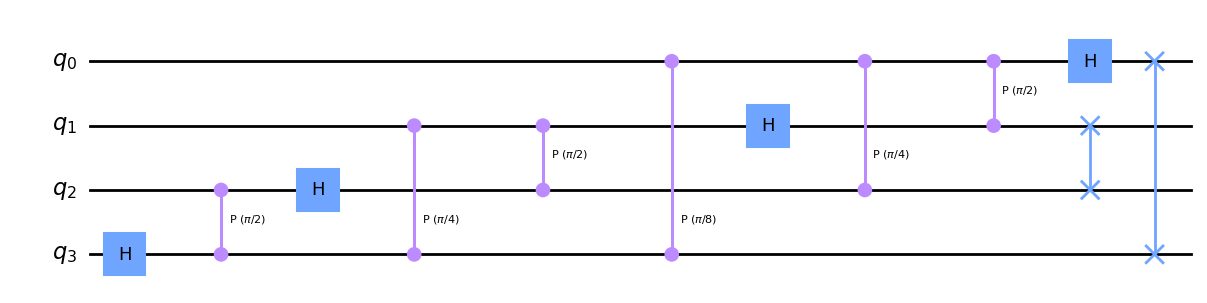

In [4]:
qft.remove_assertions().decompose().draw("mpl")

In [5]:
%%timeit -n 1 -r 5
qft = make_qft(12)
qft.run(init_state=Zero ^ Zero ^ One ^ Zero ^ Zero ^ Zero ^ One ^ Zero ^ Zero ^ Zero ^ Zero ^ Zero)

389 ms ± 12.2 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [6]:
qft = make_qft(12)
print("#qubits=")
print(qft.num_qubits)
print()
print("#gates=")
print(sum(qft.remove_assertions().count_ops().values()))

#qubits=
12

#gates=
1


In [7]:
%%timeit -n 1 -r 5
qft = make_qft(18)
qft.run()

23.3 s ± 4.04 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [8]:
qft = make_qft(18)
print("#qubits=")
print(qft.num_qubits)
print()
print("#gates=")
print(sum(qft.remove_assertions().count_ops().values()))

#qubits=
18

#gates=
1


In [9]:
%%timeit -n 1 -r 5
qft = make_qft(24)
qft.run()

27min 41s ± 3min 10s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [10]:
qft = make_qft(24)
print("#qubits=")
print(qft.num_qubits)
print()
print("#gates=")
print(sum(qft.remove_assertions().count_ops().values()))

#qubits=
24

#gates=
1


In [11]:
%xmode Minimal
qft = make_qft(4)
qft.run(init_state=Zero ^ Zero ^ One ^ Plus)

Exception reporting mode: Minimal


StateConditionError: Condition Error occured in 'QFT: qubit 0 must be |0> or |1>.'
[Info]
condition_name='QFT: qubit 0 must be |0> or |1>.'
pre_state=
  Statevector([0.        +0.j, 0.        +0.j, 0.70710678+0.j,
               0.70710678+0.j, 0.        +0.j, 0.        +0.j,
               0.        +0.j, 0.        +0.j, 0.        +0.j,
               0.        +0.j, 0.        +0.j, 0.        +0.j,
               0.        +0.j, 0.        +0.j, 0.        +0.j,
               0.        +0.j],
              dims=(2, 2, 2, 2))
post_state=None
param=None

In [12]:
from qiskit.circuit import Gate
def make_qpe(U: Gate, n: int) -> AssertQuantumCircuit[int]:
    total: int = U.num_qubits + n
    circ: AssertQuantumCircuit[int] = AssertQuantumCircuit(total)

    for i in range(n):
        circ.h(i)
        circ.append(
            U.power(2**i).control(num_ctrl_qubits=1),
            [i, *range(n, total)],
        )

    circ.append(
        make_qft(n).inverse(),
        range(n),
    )

    for i in range(n):
        circ.add_pre_condition(
            f"QPE: qubit {i} must be |0>.",
            lambda s: eq_state(s, Zero),
            focus_qubits=[i],
        )
    
    circ.add_condition(
        "QPE: post-state is equal to pre-state",
        lambda prestate, poststate: eq_state(prestate, poststate),
        focus_qubits = range(n, total)
    )
    
    def post_condition(post: Statevector, param: int) -> bool:
        return eq_state(
            Statevector.from_int(param, post.dims()), post
        )

    circ.add_post_condition_use_param(
        "QPE: postcondition",
        post_condition,
        focus_qubits=range(n),
    )

    return circ

In [13]:
from qiskit.circuit.library.standard_gates import TGate

qpe = make_qpe(TGate(), n=4)
print(qpe.run(init_state = One^Zero^Zero^Zero^Zero, param=0b0010))

Statevector([ 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
             -2.09008708e-17+4.42055068e-17j,
             -9.08073792e-17+1.83855468e-17j,
              1.00000000e+00-2.09605444e-16j,
              8.94331288e-17+8.47532085e-18j,
              3.27087709e-17-1.35893368e-17j,
              3.03300374e-17+1.473

In [14]:
from qiskit.circuit.library.standard_gates import TGate
from qiskit.opflow import One, Zero
from typing import Any
from dbcquantum.circuit import AQCMeasure

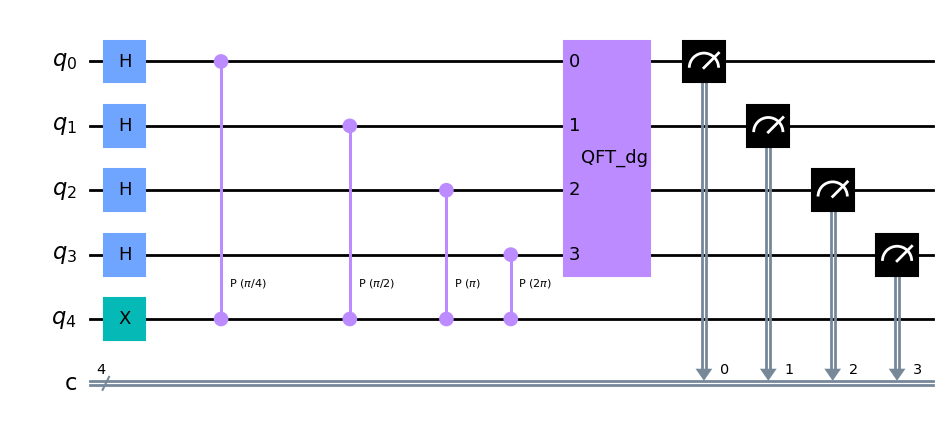

In [15]:
U = TGate()
n = 4
total = n + U.num_qubits

circ_init = AssertQuantumCircuit(1)
circ_init.x(0)
circ_init.add_pre_condition(
    "Initial circuit: State must be zero.", lambda s: eq_state(s, Zero)
)
circ_init.add_post_condition(
    "Initial circuit: State must be one.", lambda s: eq_state(s, One)
)

circ = AssertQuantumCircuit(total)
circ.append(circ_init, range(n, total))
circ.append(make_qpe(U, n), range(total))

measured: AQCMeasure[Any, str] = AQCMeasure(
    circ, postprocess=lambda r: r.get_counts(), qubit=range(n)
)
measured.remove_assertions_to_circuit().draw("mpl")

In [16]:
def to_binary(a: float, n: int) -> int:
    ans = 0

    for i in range(1, n + 1):
        if (1 / (2**i)) <= a:
            ans = ans << 1
            ans = ans + 1
            a -= 1 / (2**i)
        else:
            ans = ans << 1

    return ans

In [17]:
import numpy.linalg as LA
from cmath import log

def calc_eig(U: Gate, n: int) -> tuple[list[Statevector], list[int]]:
    eigen = LA.eig(U.to_matrix())

    states = []
    values = []

    for i in range(len(eigen[0])):
        eigenstate = Statevector(eigen[1][:, i])
        eigenvalue = eigen[0][i]
        states.append(eigenstate)
        phi: float = (log(eigenvalue) / (1j * 2 * pi)).real
        values.append(to_binary(phi, n))
    
    return (states, values)

In [18]:
T = tuple[list[Statevector], list[int]]

def whole_qpe(init_circ: AssertQuantumCircuit, U: Gate, n: int) -> AQCMeasure[dict, T]: 
    n_total = n + U.num_qubits

    circ: AssertQuantumCircuit[T] = AssertQuantumCircuit(n_total)
    circ.append(init_circ, range(n, n_total))
    # circ.barrier()
    circ.append_superposition_basis_from_param(
        "superposition",
        make_qpe(U, n),
        qargs=range(n_total),
        pre_state_basis=lambda p: p[0],
        focus_qubits=range(n, n_total),
        param_converter=lambda p: p[1],
    )

    return AQCMeasure(
        circ, 
        postprocess=lambda r: r.get_counts(), # type: ignore
        qubit=range(n)
    )

U = TGate()
n = 4
init_circ = AssertQuantumCircuit(1)
init_circ.rx(1 / 4 * pi, 0)

l = whole_qpe(init_circ, U, n).run(
    shots=1000, param=calc_eig(U, n)
)
print(l)

{'0010': 130, '0000': 870}


In [19]:
%%timeit -n 1 -r 5
n = 12

whole_qpe(init_circ, U, n).run(
    shots=1000, param=calc_eig(U, n)
)

1.5 s ± 20.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [20]:
n = 12
print("#qubits=")
print(whole_qpe(init_circ, U, n).num_qubits)
print()
print("#gates=")
print(sum(whole_qpe(init_circ, U, n).remove_assertions_to_circuit().count_ops().values()))

#qubits=
13

#gates=
38


In [21]:
%%timeit -n 1 -r 5
n = 18

whole_qpe(init_circ, U, n).run(
    shots=1000, param=calc_eig(U, n)
)

1min 36s ± 4.45 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [22]:
n = 18
print("#qubits=")
print(whole_qpe(init_circ, U, n).num_qubits)
print()
print("#gates=")
print(sum(whole_qpe(init_circ, U, n).remove_assertions_to_circuit().count_ops().values()))

#qubits=
19

#gates=
56


In [23]:
%%timeit -n 1 -r 5
n = 23

whole_qpe(init_circ, U, n).run(
    shots=1000, param=calc_eig(U, n)
)

1h 4min 59s ± 9min 21s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [24]:
n = 23
print("#qubits=")
print(whole_qpe(init_circ, U, n).num_qubits)
print()
print("#gates=")
print(sum(whole_qpe(init_circ, U, n).remove_assertions_to_circuit().count_ops().values()))

#qubits=
24

#gates=
71
